In [157]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

定义生成数据集的类

In [158]:
class Dataset:
    def __init__(self, mode='random', means1=[-5,0], means2=[0,5]):
        if mode == 'random':
            self._random_sample(means1, means2)

    def _random_sample(self, means1, means2):
        means1, means2 = np.array(means1), np.array(means2)
        covar = np.array([1,0,0,1]).reshape(2,2)
        x1, y1 = np.random.multivariate_normal(means1, covar, size=200), np.ones((200, 1))
        x2, y2 = np.random.multivariate_normal(means2, covar, size=200), np.ones((200, 1)) * -1
        self._split(x1, y1, x2, y2)

    def _split(self, x1, y1, x2, y2):
        train_n1, train_n2 = int(x1.shape[0] * 0.8), int(x2.shape[0] * 0.8)
        self.x_train = np.concatenate((x1[:train_n1], x2[:train_n2]), axis=0)
        self.y_train = np.concatenate((y1[:train_n1], y2[:train_n2]), axis=0)
        self.x_test = np.concatenate((x1[train_n1:], x2[train_n2:]), axis=0)
        self.y_test = np.concatenate((y1[train_n1:], y2[train_n2:]), axis=0)

定义算法模型 广义逆算法和梯度下降算法 **<font color="Red">（问题1）</font>**

In [159]:
class LinearRegression:
    def __init__(self, lr=None, epoch=None, mode='GD'):
        '''
        MODE
            GI: Generalized Inverses
            GD: Grandient Descent
        '''
        self.mode = mode
        self.w = np.random.randn(3,1)
        if self.mode == 'GD':
            self.lr = lr
            self.epoch = epoch
            assert(self.lr != None)
            assert(self.epoch != None)

    def __call__(self, x, y):

        x, y = x.reshape(-1,2), y.reshape(-1,1)
        expand_axis = np.ones((x.shape[0],1))
        x = np.concatenate((expand_axis, x), axis=-1)
        
        # generalized inverses method
        if self.mode == 'GI':
            x_gen_inverse = np.matmul(np.linalg.inv(np.matmul(x.T,x)),x.T)
            W = np.matmul(x_gen_inverse, y)
            self.w = W
            yh = np.matmul(x, W)
            return yh

        # grandient descent method
        if self.mode == 'GD':
            losses = []
            for i in range(self.epoch):
                yh = np.matmul(x, self.w)
                loss = L2_loss(yh, y)
                losses.append(loss)
                grad = self._calculate_grad(x, y)
                self.w -= self.lr * grad
                if i % 50 == 0:
                    print('epoch: %i  loss: %.2f'%(i, loss))

            return yh, losses

    def _calculate_grad(self, x, y):
        num_sample = x.shape[0]
        aver = (2/num_sample)
        grad = aver * np.matmul((np.matmul(x,self.w) - y).T, x)
        return grad.T


    def eval(self, x, y):
        test_num = x.shape[0]
        expand_axis = np.ones((x.shape[0],1))
        x = np.concatenate((expand_axis, x), axis=-1)
        yh = np.matmul(x, self.w)
        yh = np.sign(yh)
        assert(len(yh) == len(y))
        correct_num = len(np.where(yh == y)[0])
        print('accuracy: %.2f'%(correct_num/test_num))
        
def L2_loss(yhat, y):
    num_sample = y.shape[0]
    assert(yhat.shape == y.shape)
    loss = (1/num_sample) * np.sum((yhat - y)**2)
    return loss

生成随机点数据并可视化

Size of Dataset: 
x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


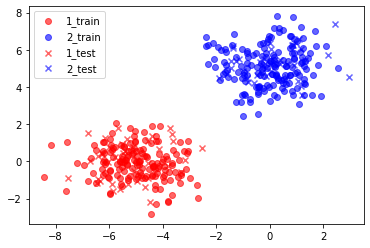

In [160]:
data1 = Dataset(mode='random')
x_train, x_test = data1.x_train, data1.x_test
y_train, y_test = data1.y_train, data1.y_test
print('Size of Dataset: ')
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

训练两个模型，统计准确率、运行时间和数据可视化。 **<font color="Red">（问题2）</font>**

使用广义逆矩阵算法直接得到W

accuracy: 1.00
w: [[-0.16642886]
 [-0.19888064]]
b: [0.08195336]


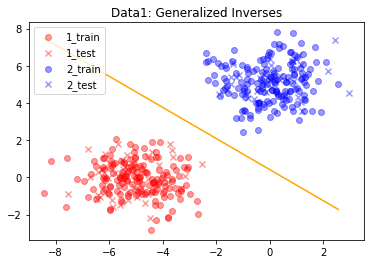

In [161]:
model1 = LinearRegression(mode='GI')
yh = model1(x_train, y_train)
model1.eval(x_test, y_test)
w, b = model1.w[1:], model1.w[0]

print('w: {}'.format(w))
print('b: {}'.format(b))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [- ( w[0] * xmin + b) / w[1],-(w[0] * xmax + b) / w[1]]
plt.plot(point1, point2, c='orange')
plt.legend(handles=[c1, c3, c2, c4], labels=['1_train', '1_test', '2_train', '2_test'], loc='best')
plt.title('Data1: Generalized Inverses')
plt.show()

使用梯度下降方法

epoch: 0  loss: 42.39
accuracy: 1.00
w: [[-0.16765816]
 [-0.19771498]]
b: [0.07654938]


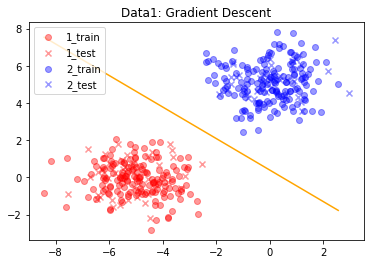

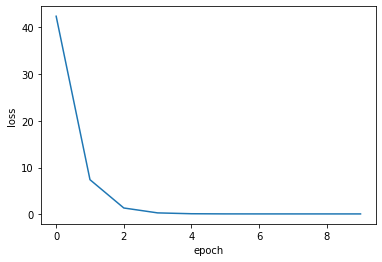

In [162]:
epoch, lr = 10, 0.02

model2 = LinearRegression(lr=lr, epoch=epoch, mode='GD')
yh, loss = model2(x_train, y_train)
model2.eval(x_test, y_test)
w, b = model2.w[1:], model2.w[0]
print('w: {}'.format(w))
print('b: {}'.format(b))

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [- ( w[0] * xmin + b) / w[1],-(w[0] * xmax + b) / w[1]]
plt.plot(point1, point2, c='orange')
plt.legend(handles=[c1, c3, c2, c4], labels=['1_train','1_test', '2_train', '2_test'], loc='best')
plt.title('Data1: Gradient Descent')
plt.show()

# loss figure
epoch = np.arange(0,epoch)
loss = np.array(loss)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

改变数据集的均值向量 **<font color="Red">（问题3）</font>**

Size of Dataset: 
x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


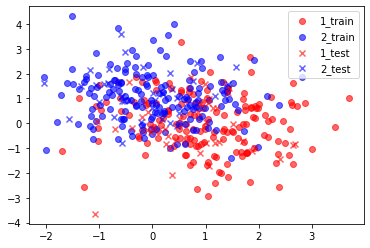

In [163]:
data2 = Dataset(mode='random', means1=[1,0], means2=[0,1])
x_train, x_test = data2.x_train, data2.x_test
y_train, y_test = data2.y_train, data2.y_test
print('Size of Dataset: ')
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

使用广义逆矩阵算法直接得到W

accuracy: 0.82
w: [[ 0.32010108]
 [-0.27797989]]
b: [-0.02357012]


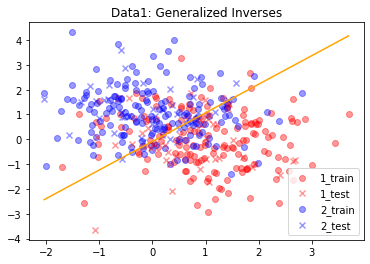

In [164]:
model1 = LinearRegression(mode='GI')
yh = model1(x_train, y_train)
model1.eval(x_test, y_test)
w, b = model1.w[1:], model1.w[0]
print('w: {}'.format(w))
print('b: {}'.format(b))

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [- ( w[0] * xmin + b) / w[1],-(w[0] * xmax + b) / w[1]]
plt.plot(point1, point2, c='orange')
plt.legend(handles=[c1, c3, c2, c4], labels=['1_train', '1_test', '2_train', '2_test'], loc='best')
plt.title('Data1: Generalized Inverses')
plt.show()

使用梯度下降法

epoch: 0  loss: 14.26
epoch: 50  loss: 0.77
accuracy: 0.80
w: [[ 0.39164467]
 [-0.22242513]]
b: [-0.14518469]


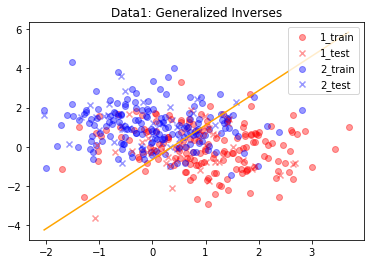

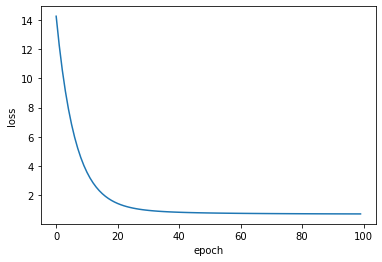

In [165]:
lr = 0.02
epoch = 100

model2 = LinearRegression(lr=lr, epoch=epoch, mode='GD')
yh, loss = model2(x_train, y_train)
model2.eval(x_test, y_test)
w, b = model2.w[1:], model2.w[0]
print('w: {}'.format(w))
print('b: {}'.format(b))

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [- ( w[0] * xmin + b) / w[1],-(w[0] * xmax + b) / w[1]]
plt.plot(point1, point2, c='orange')
plt.legend(handles=[c1, c3, c2, c4], labels=['1_train', '1_test', '2_train', '2_test'], loc='best')
plt.title('Data1: Generalized Inverses')
plt.show()

# loss figure
epoch = np.arange(0,epoch)
loss = np.array(loss)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

接下来分别测试各种optimizer的性能 **<font color="Red">（问题5）</font>**

定义函数和各种optimizer

In [166]:
class func:
    def __init__(self):
        pass

    def __call__(self, x):
        y = x * np.cos(0.25 * np.pi * x)
        grad = self._calculate_grad(x)
        return y, grad

    def _calculate_grad(self, x):
        grad = np.cos(0.25 * np.pi * x) - 0.25 * x * np.sin(0.25 * np.pi * x)
        return grad

class GD:
    def __init__(self, eps = 1e-6):
        self.eps = eps
        
    def __call__(self, grad, lr):
        return lr * grad

class Adagrad:
    def __init__(self, eps = 1e-6):
        self.sigma, self.t, self.eps = 0, 0, eps
        
    def __call__(self, grad, lr):
        self.sigma = np.math.sqrt(((self.sigma**2) * self.t + grad**2)/(self.t + 1)) + self.eps
        self.t = self.t + 1
        return (lr * grad) / self.sigma

class RMSProp(Adagrad):
    def __init__(self, alpha=0.9):
        super(RMSProp,self).__init__()
        self.alpha = alpha
        
    def __call__(self, grad, lr):
        self.sigma = np.math.sqrt(self.alpha * self.sigma + (1-self.alpha)*grad**2)
        return (lr * grad) / self.sigma

class Momentum:
    def __init__(self, lamda=0.9):
        self.m, self.lamda = 0, lamda

    def __call__(self, grad, lr):
        self.m = - self.lamda * self.m + lr*grad
        return self.m

class Adam():
    def __init__(self, b1=0.9, b2=0.99, eps=1e-6):
        self.b1, self.b2 = b1, b2
        self.eps = eps
        self.m, self.v, self.t = 0, 0, 1

    def __call__(self, grad, lr):
        self.m = self.b1 * self.m + (1-self.b1) * grad
        self.v = self.b2 * self.v + (1-self.b2) * grad**2
        # bias correction
        if self.t < 5:
            m, v = self.m/(1 - self.b1**self.t), self.v/(1 - self.b2**self.t)
        else:
            m, v = self.m, self.v
        return lr * m / (np.math.sqrt(v) + self.eps)

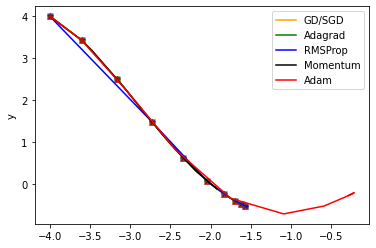

In [167]:
epoch = 10
lr = 0.4

f = func()
x, y = np.ones(4) * -4, np.ones(4) * f(-4)[0]
grad = np.zeros(4)
optim = [Adagrad(), RMSProp(), Momentum(), Adam()]

xs, ys = [], []
for i in range(epoch):
    # calculate current value
    for j in range(4):
        y[j], grad[j] = f(x[j])
    # save result
    xs.append([x[0], x[1], x[2], x[3]])
    ys.append([y[0], y[1], y[2], y[3]])
    # update
    for j in range(4):
        x[j] -= optim[j](grad[j], lr)
xs, ys = np.array(xs), np.array(ys)

# show result
plt.plot(xs[:, 0],ys[:, 0], c='green', label='Adagrad')
plt.plot(xs[:, 1],ys[:, 1], c='blue', label='RMSProp')
plt.plot(xs[:, 2],ys[:, 2], c='black', label='Momentum')
plt.plot(xs[:, 3],ys[:, 3], c='red', label='Adam')

plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='green', marker='o')
plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='blue', marker='x')
plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='black', marker='*')
plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='red', marker='^')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

* 各个优化策略在本问题上效果几乎一致
* Adam优化速度较快，其momentum机制会使其越过最优l点

修改Adam的beta1为0.99，并迭代50次

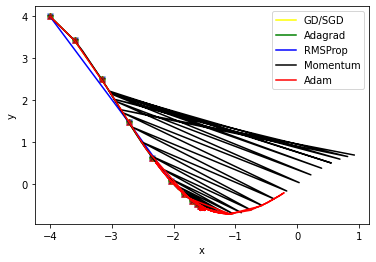

In [168]:
epoch = 50
lr = 0.4

f = func()
x, y = np.ones(5) * -4, np.ones(5) * f(-4)[0]
grad = np.zeros(5)
optimizer = [GD(), Adagrad(), RMSProp(), Momentum(), Adam(b1=0.9)]

xs, ys = [], []
for i in range(epoch):
    # calculate current value
    for j in range(5):
        y[j], grad[j] = f(x[j])
    # save result
    xs.append([x[0], x[1], x[2], x[3], x[4]])
    ys.append([y[0], y[1], y[2], y[3], y[4]])
    # update
    for j in range(5):
        x[j] -= optimizer[j](grad[j], lr)
xs, ys = np.array(xs), np.array(ys)

# show result
plt.plot(xs[:, 0],ys[:, 0], c='yellow', label='GD/SGD')
plt.plot(xs[:, 1],ys[:, 1], c='green', label='Adagrad')
plt.plot(xs[:, 2],ys[:, 2], c='blue', label='RMSProp')
plt.plot(xs[:, 3],ys[:, 3], c='black', label='Momentum')
plt.plot(xs[:, 4],ys[:, 4], c='red', label='Adam')

plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='yellow', marker='p')
plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='green', marker='o')
plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='blue', marker='x')
plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='black', marker='*')
plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='red', marker='^')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

* momentum并没有对梯度进行自适应，使其越过最优点且振动幅度越来越大，最后不能收敛